## Example of learning the prior density parameters using nnTreeVB framework

Amine Remita

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nnTreeVB.data import evolve_seqs_full_homogeneity    
from nnTreeVB.data import build_tree_from_nwk
from nnTreeVB.data import simulate_tree
from nnTreeVB.data import build_msa_categorical
from nnTreeVB.data import TreeSeqCollection
#
from nnTreeVB.checks import check_sim_blengths
from nnTreeVB.checks import check_sim_simplex
#
from nnTreeVB.reports import plot_weights_grads_epochs
from nnTreeVB.reports import violinplot_from_dataframe
#
from nnTreeVB.models.vb_models import VB_nnTree

In [3]:
import time
import math
import random
import copy
from pprint import pprint
from collections import OrderedDict

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from scipy import stats

np.set_printoptions(precision=5)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', "r'All-NaN (slice|axis) encountered'")

In [5]:
verbose = True

device = torch.device("cpu")
# # device = torch.device("cuda")

In [6]:
# seed = 49685
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Sequence alignment simulation

In [7]:
fasta_file = 'sim.fasta'
tree_file = 'sim.nw'

In [8]:
alignment_len = 1000
nb_taxa = 32

In [9]:
# Mean & variance distribution for branch lengths simulation

mean = 0.001
rate = 1 / mean
variance = 1/rate**2

print("rate ", rate)
print("variance ", variance)

rate  1000.0
variance  1e-06


In [10]:
sim_blengths = check_sim_blengths("exponential({})".format(rate), nb_taxa)[0]

print("Simulated brench lengths:")
print("Number: {}".format(len(sim_blengths)))
print("Mean: {}".format(np.mean(sim_blengths)))
print("Variance: {}".format(np.var(sim_blengths)))
print("Tree length: {}".format(np.sum(sim_blengths)))


Simulated brench lengths:
Number: 61
Mean: 0.0008526261552825608
Variance: 1.2449080591739317e-06
Tree length: 0.05201019547223621


In [11]:
# Tree topology simulation

tree_data = simulate_tree(nb_taxa, sim_blengths, seed)

the_tree = tree_data[0]
taxa = list(tree_data[1].keys())

logl_tree = copy.deepcopy(the_tree)

str_tree = the_tree.write(format=1)

In [12]:
# write newick file
the_tree.write(format=1, outfile=tree_file)

In [13]:
# unrooted tree => the root has three node children
len(the_tree.get_children())

3

In [14]:
# Sequence evolutionary parameters simulation

# uniform distributed substitution rates
evo_rates = check_sim_simplex("0.166", 6)[0]
sim_rates = copy.deepcopy(evo_rates)

# uniform distributed relative frequencies
evo_freqs = check_sim_simplex("0.25", 4)[0]
sim_freqs = copy.deepcopy(evo_freqs)
sim_freqs[1], sim_freqs[2] = sim_freqs[2], sim_freqs[1]

In [15]:
all_seqdict = evolve_seqs_full_homogeneity(
        str_tree,
        fasta_file=False,
        nb_sites=alignment_len,
        subst_rates=sim_rates,
        state_freqs=sim_freqs,
        return_anc=True,
        verbose=verbose)

sequences = [all_seqdict[s] for s in taxa]
seq_taxa = {s:all_seqdict[s] for s in taxa}

Evolving sequences with the amazing Pyvolve


In [16]:
# write fasta file
records = [SeqRecord(Seq(seq_taxa[taxon]), taxon, '', '') for taxon in seq_taxa]
SeqIO.write(records, fasta_file, "fasta")

32

In [17]:
gtr_freqs = torch.tensor(evo_freqs)
print("\nFrequencies")
print(gtr_freqs)
print(gtr_freqs.sum())

gtr_rates = torch.tensor(evo_rates) # AG, AC, AT, GC, GT, CT
print("\nRelative rates")
print(gtr_rates)
print(gtr_rates.sum())


Frequencies
tensor([0.2500, 0.2500, 0.2500, 0.2500])
tensor(1.)

Relative rates
tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])
tensor(1.)


In [18]:
true_branches = torch.zeros(len(the_tree.get_descendants()))
# print(true_branches.shape[0])

for node in the_tree.traverse("postorder"):

    if node.postrank < true_branches.shape[0]:
#         print(node.name, node.rank, node.dist)
        true_branches[node.postrank] = node.dist

true_branches = true_branches.unsqueeze(-1)
print("\ntrue_branches")
print(len(true_branches))
print(true_branches.sum())


true_branches
61
tensor(0.0520)


In [19]:
treeseqs = TreeSeqCollection(fasta_file, tree_file)
the_tree = treeseqs.tree
logl_tree = copy.deepcopy(the_tree)

In [20]:
# motifs_cats = build_msa_categorical(sequences, nuc_cat=False)
motifs_cats = build_msa_categorical(treeseqs, nuc_cat=False)
X = torch.from_numpy(motifs_cats.data)
V = X.clone().detach()
V_counts = torch.ones(V.shape[0]).detach()
# X_counts = torch.ones(X.shape[0])
X, X_counts = X.unique(dim=0, return_counts=True)

print(X.shape)  # [n_dim, m_dim, x_dim]
# print(X_counts)

torch.Size([44, 32, 4])


### True log likelihood using JC69 model

In [21]:
from nnTreeVB.models.evo_models import pruning
from nnTreeVB.models.evo_models import build_JC69_transition_matrix

with torch.no_grad():

    tm = build_JC69_transition_matrix(true_branches.unsqueeze(0).squeeze(2))
#     tm = build_JC69_transition_matrix(true_branches)
    freqs = torch.ones(4)/4
#     true_lls = (pruning(logl_tree, X.unsqueeze(0), tm, freqs.unsqueeze(0)) * X_counts).sum()
    true_lls = (pruning(logl_tree, X, tm, freqs.unsqueeze(0)) * X_counts).sum()

true_lls

tensor(-1793.0864)

In [22]:
# Using compute_log_likelihood function

from nnTreeVB.models.evo_models import compute_log_likelihood

freqs = torch.ones(4)/4

tm_args = {"b":true_branches.unsqueeze(0).squeeze(2)}

with torch.no_grad():
    true_lls = (compute_log_likelihood(
        logl_tree,
#         X.unsqueeze(0),
        X,
        "jc69",
        tm_args,
        freqs,
        rescaled_algo=False
    ) * X_counts).sum()

true_lls

tensor(-1793.0864)

## Fitting and sampling nnTreeVB models
#### Hyperparameters

In [23]:
# Hyper parameters

# Number of sequences
m_dim = len(the_tree.get_leaf_names())
# Number of branches
b_dim = len(the_tree.get_edges()) - 1

h_dim = 32
nb_layers = 10
# activ_layers=False
activ_layers="relu"
# activ_layers="tanh"
bias_layers=True
dropout_layers=0.

# alpha_kl = 0.0001
print(m_dim)
print(b_dim)

32
61


In [24]:
# Fitting parameters
n_epochs = 1000

learning_rate = {
    "b_dist_q":0.1,
    "default":0.1}

weight_decay = 0.0

# optim = "sgd"
optim = "adam"

lr_lambda=lambda epoch: 1.0
# lr_lambda=lambda epoch: 1.0 / (epoch + 1)**0.5 # from torchtree

elbo_type="elbo"
# elbo_type="elbo_kl"
# elbo_type="elbo_iws"

alpha_kl = 1.

grad_samples = torch.Size([1])          # elbo and elbo_kl
# grad_samples = torch.Size([10, 100])  # elbo_iws

nb_samples = torch.Size([1000])         # elbo and elbo_kl
# nb_samples = torch.Size([1, 10])      # elbo_iws

### 1. VB_nnTree with JC69 model and fixed prior density (VP-FPD-JC69)
#### VP-FPD-JC69 model initialization

In [28]:
FPD_jc69 = VB_nnTree(
    copy.deepcopy(the_tree),
    subs_model="jc69",

    ## branch length prior
    b_prior_dist="exponential",
    b_prior_params=[10.],      # rate 10 (mean 0.1)
    b_learn_prior=False,       # fixed prior

    ## branch length variational
    b_var_dist="normal",
    b_var_params=[0.1, 0.1],
    b_var_transform=torch.distributions.ExpTransform(),
    
    ##
    device=device
)

In [29]:
FPD_jc69.b_dist_p.learn_params

False

#### VP-FPD-JC69 model fitting

In [30]:
FPD_jc69_fit = FPD_jc69.fit(
    X, 
    X_counts,
    elbo_type=elbo_type,
    grad_samples=grad_samples,
    alpha_kl=alpha_kl,
    max_iter=n_epochs,
    optimizer=optim,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    scheduler_lambda=lr_lambda,
    save_fit_history=True,
    save_grad_stats=True,
    save_weight_stats=True,
    verbose=1
)

In [31]:
list(FPD_jc69_fit.keys())

['total_fit_time',
 'optimized',
 'elbos_list',
 'lls_list',
 'lps_list',
 'lqs_list',
 'kls_list',
 'fit_estimates',
 'grad_stats',
 'weight_stats']

#### VP-FPD-JC69 model sampling

In [32]:
FPD_jc69_samples = FPD_jc69.sample(
    X, 
    X_counts,
    elbo_type=elbo_type,
    alpha_kl=alpha_kl,
    nb_samples=nb_samples
)

In [33]:
# Log likelihood of data given estimated branch lengths
FPD_jc69_samples["logl"]

array(-1831.1066, dtype=float32)

In [34]:
# estimated branch lengths

print(FPD_jc69_samples["b"].mean(0))
print(FPD_jc69_samples["b"].mean(0).sum())
print(FPD_jc69_samples["b"].mean())

[0.00127 0.00138 0.00138 0.00127 0.00329 0.00135 0.00208 0.00371 0.00121
 0.00146 0.00122 0.00223 0.00306 0.00273 0.00166 0.00108 0.00154 0.0012
 0.00314 0.00224 0.00122 0.0017  0.00386 0.00107 0.00125 0.00115 0.00419
 0.00121 0.00141 0.00107 0.00246 0.00114 0.00137 0.0012  0.00309 0.00337
 0.00325 0.00116 0.00115 0.00204 0.00199 0.00106 0.00119 0.0021  0.00407
 0.00523 0.00148 0.00127 0.00184 0.00217 0.00113 0.00146 0.00129 0.00142
 0.00213 0.00647 0.00119 0.0013  0.0014  0.00099 0.00134]
0.119350344
0.0019565632


<Figure size 640x480 with 0 Axes>

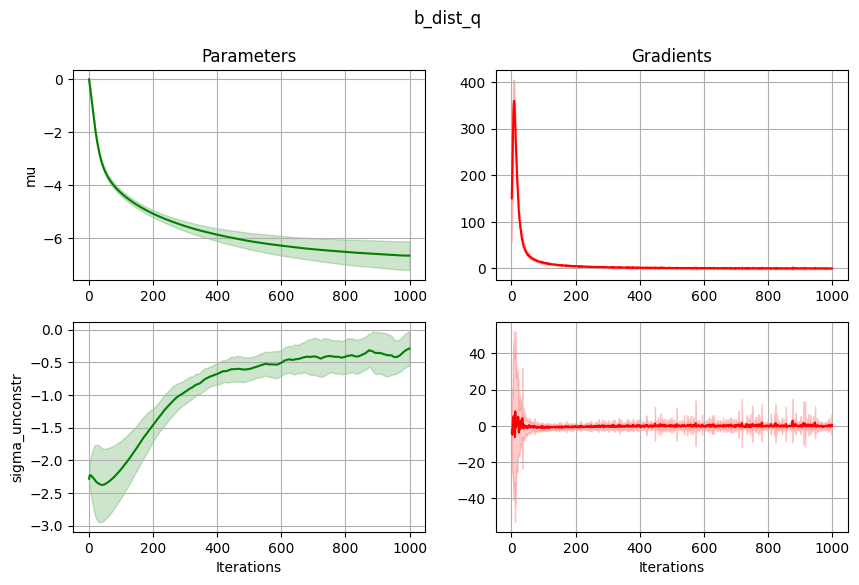

In [35]:
plot_weights_grads_epochs(FPD_jc69_fit, 'b_dist_q', False, sizefont=10, fig_size=(10,3))

### VB_nnTree with JC69 model and adaptable prior density (VP-LPD-JC69)
#### VP-FPD-JC69 model initialization

In [36]:
LPD_jc69 = VB_nnTree(
    copy.deepcopy(the_tree),
    subs_model="jc69",

    ## branch length prior
    b_prior_dist="exponential",
    b_prior_params="uniform",  # random sampled initialization for prior parameter 
    b_learn_prior=True,        # learned prior

    ## branch length variational
    b_var_dist="normal",
    b_var_params=[0.1, 0.1],
    b_var_transform=torch.distributions.ExpTransform(),
    
    ##
    device=device
)

In [37]:
LPD_jc69.b_dist_p.learn_params

True

#### VP-LPD-JC69 model fitting

In [38]:
LPD_jc69_fit = LPD_jc69.fit(
    X,
    X_counts,
    elbo_type=elbo_type,
    grad_samples=grad_samples,
    alpha_kl=alpha_kl,
    max_iter=n_epochs,
    optimizer=optim,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    scheduler_lambda=lr_lambda,
    save_fit_history=True,
    save_grad_stats=True,
    save_weight_stats=True,
    verbose=1
)

#### VP-LPD-JC69 model sampling

In [39]:
LPD_jc69_samples = LPD_jc69.sample(
    X, 
    X_counts,
    elbo_type=elbo_type,
    alpha_kl=alpha_kl,
    nb_samples=nb_samples
)

In [40]:
# Log likelihood of data given estimated branch lengths
LPD_jc69_samples["logl"]

array(-1797.9663, dtype=float32)

In [41]:
# estimated branch lengths

print(LPD_jc69_samples["b"].mean(0))
print(LPD_jc69_samples["b"].mean(0).sum())
print(LPD_jc69_samples["b"].mean())

[0.00059 0.00055 0.00056 0.00067 0.00202 0.00062 0.00109 0.0032  0.00068
 0.00061 0.0006  0.00108 0.00186 0.00191 0.00058 0.00053 0.00064 0.00072
 0.00205 0.0012  0.00053 0.00127 0.00306 0.00055 0.00071 0.00063 0.00324
 0.00053 0.00053 0.00053 0.001   0.00063 0.0006  0.00054 0.00192 0.00224
 0.00209 0.00041 0.00055 0.00108 0.00111 0.00049 0.00046 0.00125 0.00342
 0.004   0.00041 0.00046 0.00126 0.00121 0.00056 0.00047 0.00053 0.00061
 0.00115 0.00631 0.00046 0.00057 0.00048 0.00049 0.00048]
0.07055066
0.0011565682


<Figure size 640x480 with 0 Axes>

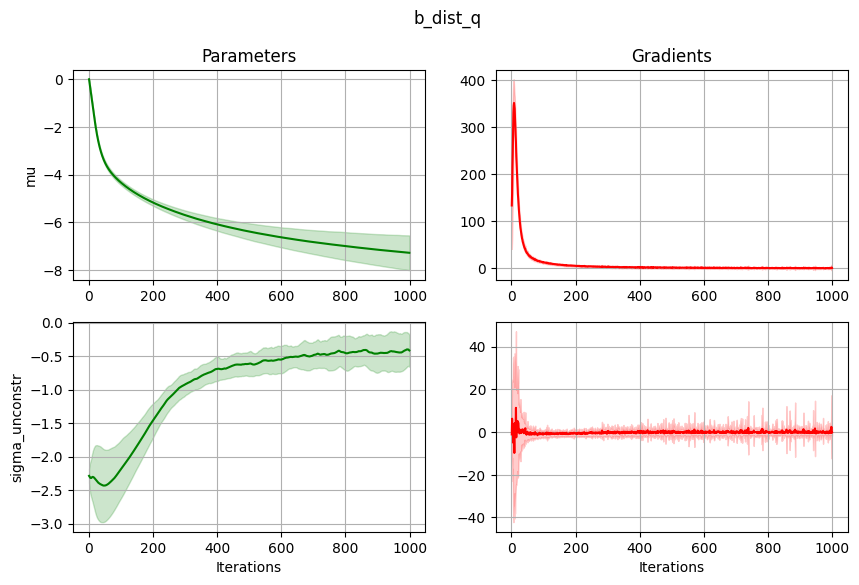

<Figure size 640x480 with 0 Axes>

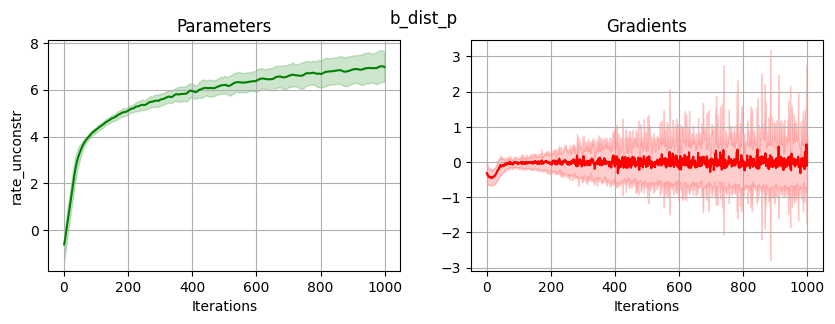

In [42]:
plot_weights_grads_epochs(LPD_jc69_fit, 'b_dist_q', False, sizefont=10, fig_size=(10,3))

plot_weights_grads_epochs(LPD_jc69_fit, 'b_dist_p', False, sizefont=10, fig_size=(10,3))

### Comparison of branch length estimates between VP-FPD-JC69 (fixed prior) and VP-LPD-J69 (adaptable prior)

In [43]:
# from nnTreeVB.reports import violinplot_from_dataframe
data = np.vstack((FPD_jc69_samples["b"].sum(1), LPD_jc69_samples["b"].sum(1))).T
data.shape

(1000, 2)

In [44]:
df = pd.DataFrame(data=data, columns=["FPD", "LPD"])
df.describe()

,FPD,LPD
count,1000.000000,1000.000000
mean,0.119350,0.070551
std,0.013697,0.007282
min,0.080648,0.050010
25%,0.110198,0.065333
50%,0.118207,0.070027
75%,0.127473,0.075225
max,0.186393,0.095592


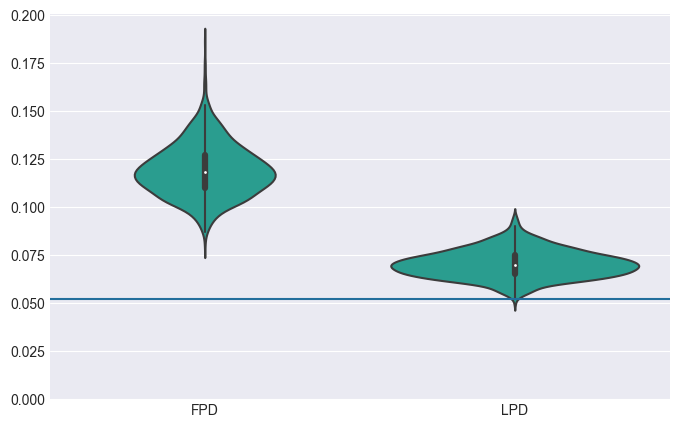

In [45]:
true_tree_len = true_branches.sum().item() # horizontal line
violinplot_from_dataframe(df, line=true_tree_len, y_limit=[0, None])